# Texture networks

Fast neural style transfer

In [1]:
from collections import namedtuple

import matplotlib.pyplot as plt
from tqdm import tqdm
import numpy as np
from PIL import Image
import torch.nn as nn

import torch
from torchvision import models, transforms
from torch.autograd import Variable

from IPython.display import clear_output

In [2]:
# loss network

LossOutput = namedtuple(
    "LossOutput", ["relu1", "relu2", "relu3", "relu4", "relu5"])


class LossNetwork(torch.nn.Module):
    """
    Reference:
        https://discuss.pytorch.org/t/how-to-extract-features-of-an-image-from-a-trained-model/119/3
    """

    def __init__(self):
        super(LossNetwork, self).__init__()
        self.vgg_layers = models.vgg19(pretrained=True).features
        self.layer_name_mapping = {
            '3': "relu1",
            '8': "relu2",
            '17': "relu3",
            '26': "relu4",
            '35': "relu5",
        }

    def forward(self, x):
        output = {}
        for name, module in self.vgg_layers._modules.items():
            x = module(x)
            if name in self.layer_name_mapping:
                output[self.layer_name_mapping[name]] = x
        return LossOutput(**output)

In [3]:
class Vgg16(torch.nn.Module):
    def __init__(self, requires_grad=False):
        super(Vgg16, self).__init__()
        vgg_pretrained_features = models.vgg16(pretrained=True).features
        self.slice1 = torch.nn.Sequential()
        self.slice2 = torch.nn.Sequential()
        self.slice3 = torch.nn.Sequential()
        self.slice4 = torch.nn.Sequential()
        for x in range(4):
            self.slice1.add_module(str(x), vgg_pretrained_features[x])
        for x in range(4, 9):
            self.slice2.add_module(str(x), vgg_pretrained_features[x])
        for x in range(9, 16):
            self.slice3.add_module(str(x), vgg_pretrained_features[x])
        for x in range(16, 23):
            self.slice4.add_module(str(x), vgg_pretrained_features[x])
        if not requires_grad:
            for param in self.parameters():
                param.requires_grad = False

    def forward(self, X):
        h = self.slice1(X)
        h_relu1_2 = h
        h = self.slice2(h)
        h_relu2_2 = h
        h = self.slice3(h)
        h_relu3_3 = h
        h = self.slice4(h)
        h_relu4_3 = h
        vgg_outputs = namedtuple("VggOutputs", ['relu1_2', 'relu2_2', 'relu3_3', 'relu4_3'])
        out = vgg_outputs(h_relu1_2, h_relu2_2, h_relu3_3, h_relu4_3)
        return out

In [4]:
def gram_matrix(y):
    (b, ch, h, w) = y.size()
    features = y.view(b, ch, w * h)
    features_t = features.transpose(1, 2)
    #print(features.shape)
    #print(features_t.shape)
    gram = features.bmm(features_t) / (ch * h * w)
    return gram

In [5]:
def generate_patches(patch_num, np_img, points):
    patches = np.zeros((patch_num, IMG_SIZE, IMG_SIZE, 3))
    for i in range(patch_num):
        num = np.random.randint(4)
        x, y = points[num][0], points[num][1]
        patches[i] = np_img[x:x+IMG_SIZE, y:y+IMG_SIZE, :3]
    return patches

In [6]:
filename = 'train.jpg'

RANDOM_SEED = 1
IMG_SIZE = 400
batch_size = 5

np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

use_cuda = True

vgg = Vgg16(requires_grad=False)

if use_cuda:
    vgg = vgg.cuda()

vgg.eval()
    
img = Image.open(filename)
print(img.size)
x,y = np.random.randint(low=0, high = min(img.size)-IMG_SIZE, size=2)
np_img = np.asarray(img)[x:x+IMG_SIZE,y:y+IMG_SIZE,:3]/255.0
print(np_img.reshape((np_img.shape[0]*np_img.shape[1], -1)).mean(axis=0))
print(np_img.reshape((np_img.shape[0]*np_img.shape[1], -1)).std(axis=0))

#np_img = np.clip(np_img, 0, 1)
#np_img = np_img[:,:,None]

#patches = generate_patches(4, np_img, points)

transform = transforms.Compose([
    transforms.ToTensor(), 
    transforms.Normalize(mean=[0.3858, 0.3858, 0.3858], std=[0.2716, 0.2716, 0.2716])
])

#styles = [transform(patch) for patch in patches]

#style = styles[0]

#print(style.shape)
#style = transform(np_img)
#style = style.repeat(batch_size, 1, 1, 1)
'''
for i in range(batch_size):
    num = np.random.randint(4)
    style[i] = styles[num]
'''

#if use_cuda:
#    style = style.cuda()
    
#features_style = vgg(normalize_batch(style))
#gram_style = [gram_matrix(y) for y in features_style]

(757, 757)
[0.38583811 0.38583811 0.38583811]
[0.27155763 0.27155763 0.27155763]


'\nfor i in range(batch_size):\n    num = np.random.randint(4)\n    style[i] = styles[num]\n'

In [7]:
tmp = np_img[:,:,1]

In [8]:
np_img = np.repeat(tmp[:,:,None], 3, axis = 2)

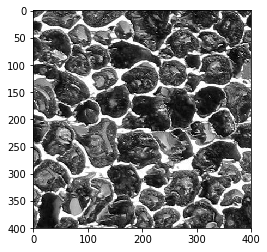

In [9]:
plt.imshow(np_img, cmap = 'gray')

In [10]:
style = transform(np_img)

In [11]:
if use_cuda:
    style = style.cuda()
    
style = style.repeat(batch_size, 1, 1, 1)

In [12]:
style[0].permute(1,2,0).shape

torch.Size([400, 400, 3])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


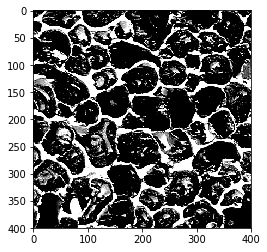

In [13]:
plt.imshow(style[0].permute(1,2,0).cpu().data.numpy())

In [14]:
plt.imsave('initial_alporas_norm.jpg', np.clip(style[0].permute(1,2,0).cpu().data.numpy(), 0, 1))

In [15]:
# deep image prior

class GenNoise(nn.Module):
    def __init__(self, dim2):
        super(GenNoise, self).__init__()
        self.dim2 = dim2

    def forward(self, input):
        a = list(input.size())
        a[1] = self.dim2
        # print (input.data.type())

        b = torch.zeros(a).type_as(input.data)
        b.normal_()

        x = torch.autograd.Variable(b)

        return x

In [16]:
def add_module(self, module):
    self.add_module(str(len(self) + 1), module)
    
torch.nn.Module.add = add_module

class Concat(nn.Module):
    def __init__(self, dim, *args):
        super(Concat, self).__init__()
        self.dim = dim

        for idx, module in enumerate(args):
            self.add_module(str(idx), module)

    def forward(self, input):
        inputs = []
        for module in self._modules.values():
            inputs.append(module(input))

        inputs_shapes2 = [x.shape[2] for x in inputs]  # width
        inputs_shapes3 = [x.shape[3] for x in inputs]   # height     

        if np.all(np.array(inputs_shapes2) == min(inputs_shapes2)) and np.all(np.array(inputs_shapes3) == min(inputs_shapes3)):
            inputs_ = inputs
        else:
            target_shape2 = min(inputs_shapes2)
            target_shape3 = min(inputs_shapes3)

            inputs_ = []
            for inp in inputs: 
                diff2 = (inp.size(2) - target_shape2) // 2 
                diff3 = (inp.size(3) - target_shape3) // 2 
                inputs_.append(inp[:, :, diff2: diff2 + target_shape2, diff3:diff3 + target_shape3])
        #print(target_shape2)
        return torch.cat(inputs_, dim=self.dim)

    def __len__(self):
        return len(self._modules)

def act(act_fun = 'LeakyReLU'):
    '''
        Either string defining an activation function or module (e.g. nn.ReLU)
    '''
    if isinstance(act_fun, str):
        if act_fun == 'LeakyReLU':
            return nn.LeakyReLU(0.2, inplace=True)
        elif act_fun == 'ELU':
            return nn.ELU()
        elif act_fun == 'none':
            return nn.Sequential()
        else:
            assert False
    else:
        return act_fun()

In [17]:
class Interpolate(nn.Module):
    def __init__(self, size=None, scale_factor=None, mode='nearest', align_corners=False):
        super(Interpolate, self).__init__()
        self.interp = nn.functional.interpolate
        self.size = size
        self.mode = mode
        self.scale_factor = scale_factor
        self.align_corners = align_corners
        
    def forward(self, x):
        x = self.interp(x, size=self.size, scale_factor=self.scale_factor, 
                        mode=self.mode)
        return x

In [18]:
normalization = nn.BatchNorm2d


def conv(in_f, out_f, kernel_size, stride=1, bias=True, pad='zero'):
    if pad == 'zero':
        #print()
        return nn.Conv2d(in_f, out_f, kernel_size, stride, padding=(kernel_size - 1) // 2, bias=bias)
    elif pad == 'reflection':
        layers = [nn.ReflectionPad2d((kernel_size - 1) / 2),
                  nn.Conv2d(in_f, out_f, kernel_size, stride, padding=0, bias=bias)]
        return nn.Sequential(*layers)

def get_texture_nets(inp=3, ratios = [32, 16, 8, 4, 2, 1], fill_noise=True, pad='zero', need_sigmoid=False, conv_num=8, upsample_mode='nearest'):

    for i in range(len(ratios)):
        j = i + 1

        seq = nn.Sequential()

        #tmp =  nn.AvgPool2d(ratios[i], ratios[i])

        #seq.add(tmp)
        if fill_noise:
            seq.add(GenNoise(inp))

        seq.add(conv(inp, conv_num, 3, pad=pad))
        seq.add(normalization(conv_num))
        seq.add(act())

        seq.add(conv(conv_num, conv_num, 3, pad=pad))
        seq.add(normalization(conv_num))
        seq.add(act())

        seq.add(conv(conv_num, conv_num, 1, pad=pad))
        seq.add(normalization(conv_num))
        seq.add(act())

        if i == 0:
            seq.add(Interpolate(scale_factor=2, mode=upsample_mode))
            cur = seq
        else:

            cur_temp = cur

            cur = nn.Sequential()

            # Batch norm before merging 
            seq.add(normalization(conv_num))
            cur_temp.add(normalization(conv_num * (j - 1)))
            
            cur.add(Concat(1, cur_temp, seq))

            cur.add(conv(conv_num * j, conv_num * j, 3, pad=pad))
            cur.add(normalization(conv_num * j))
            cur.add(act())

            cur.add(conv(conv_num * j, conv_num * j, 3, pad=pad))
            cur.add(normalization(conv_num * j))
            cur.add(act())

            cur.add(conv(conv_num * j, conv_num * j, 1, pad=pad))
            cur.add(normalization(conv_num * j))
            cur.add(act())

            if i == len(ratios) - 1: 
                cur.add(conv(conv_num * j, 3, 1, pad=pad))
            else:
                cur.add(Interpolate(scale_factor=2, mode=upsample_mode)) 
            
    model = cur
    if need_sigmoid:
        model.add(nn.Sigmoid())

    return model

In [19]:
texture_net = get_texture_nets(3, upsample_mode='nearest')
empty = torch.zeros(style.shape).float()

if use_cuda:
    texture_net = texture_net.cuda()
    empty = empty.cuda()

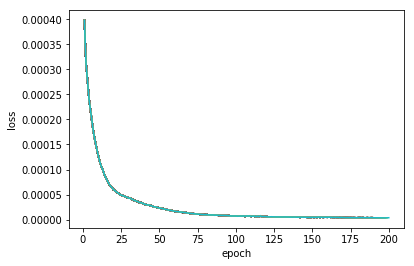

In [20]:
features_style = vgg(style.cuda().float())

gram_style = [gram_matrix(y) for y in features_style]

num_epochs = 200
mse_loss = torch.nn.MSELoss()
optimizer = torch.optim.Adam(texture_net.parameters())
losses = []
for epoch in range(num_epochs):
    
    #empty = torch.zeros(style.shape)
    synthesized_texture = texture_net(empty)
    
    features_synthesized = vgg(synthesized_texture)
    
    loss = 0.
    #for ft, st in zip(features_synthesized, features_style):
    for ft, gm_s in zip(features_synthesized, gram_style):
        gm_y = gram_matrix(ft)
        loss += mse_loss(gm_y, gm_s[:batch_size, :, :])
    losses.append(float(loss.data.cpu()))
    clear_output(wait=True)
    plt.plot(np.arange(1, epoch+2),losses)
    plt.xlabel('epoch')
    plt.ylabel('loss')
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


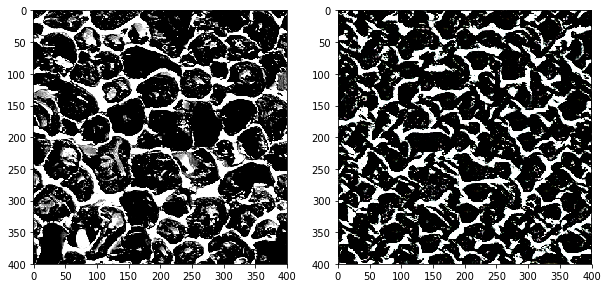

In [21]:
size = 400

empty = torch.zeros(1, 3, size, size).float()

if use_cuda:
    empty = empty.cuda()
    
synthesized_texture = texture_net(empty)
res = synthesized_texture[0].data.cpu().permute(1,2,0).numpy()   


plt.figure(figsize=(10,10))
plt.subplot(121)
plt.imshow(np.clip(np_img, 0, 1))
plt.subplot(122)
plt.imshow(res)

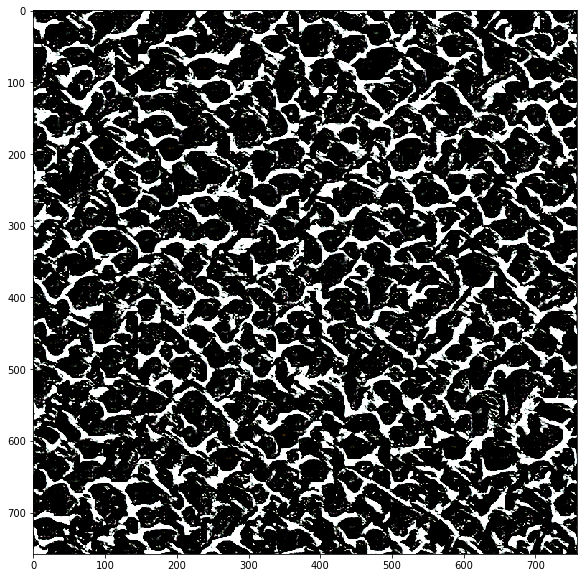

In [22]:
size = 758

empty = torch.zeros(1, 3, size, size).float()

if use_cuda:
    empty = empty.cuda()
    
synthesized_texture = texture_net(empty)
res = synthesized_texture[0].permute(1,2,0).data.cpu().numpy().squeeze()    

plt.figure(figsize=(10,10))
plt.imshow(np.clip(res,0,1))

In [23]:
#plt.imshow(np.clip(synthesized_texture.data.cpu().numpy().squeeze()[0].reshape(IMG_SIZE,IMG_SIZE,3), 0,1))
plt.imsave('texture_network_synthesized_alporas_norm.jpg', np.clip(res, 0 ,1))

In [15]:
vgg = Vgg16(requires_grad=False)

if use_cuda:
    vgg = vgg.cuda()

In [19]:
vgg.eval()

Vgg16(
  (slice1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace)
  )
  (slice2): Sequential(
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace)
  )
  (slice3): Sequential(
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace)
  )
  (slice4): Sequential(
    (16): MaxPool

In [10]:
filename = 'initial.jpg'

RANDOM_SEED = 1
IMG_SIZE = 256
batch_size = 10

np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

use_cuda = True

vgg = Vgg16(requires_grad=False)

if use_cuda:
    vgg = vgg.cuda()

vgg.eval()
    
for i in tqdm(range(6,50)):
    
    # initalizaion


    img = Image.open(filename)
    x,y = np.random.randint(low=0, high = min(img.size)-IMG_SIZE, size=2)
    np_img = np.asarray(img)[x:x+IMG_SIZE,y:y+IMG_SIZE,:3]/255.0
    #print(np_img.reshape((np_img.shape[0]*np_img.shape[1], -1)).mean(axis=0))
    #print(np_img.reshape((np_img.shape[0]*np_img.shape[1], -1)).std(axis=0))


    transform = transforms.Compose([
        transforms.ToTensor(), 
        transforms.Normalize(mean=[0.432, 0.432, 0.432], std=[0.281, 0.281, 0.281])
    ])

    #styles = [transform(patch) for patch in patches]

    #style = styles[0]

    #print(style.shape)
    style = transform(np_img)
    style = style.repeat(batch_size, 1, 1, 1)
    '''
    for i in range(batch_size):
        num = np.random.randint(4)
        style[i] = styles[num]
    '''

    if use_cuda:
        style = style.cuda()

    #features_style = vgg(normalize_batch(style))
    #gram_style = [gram_matrix(y) for y in features_style]
    texture_net = get_texture_nets(upsample_mode='nearest')
    empty = torch.zeros(style.shape).float()

    if use_cuda:
        texture_net = texture_net.cuda()
        empty = empty.cuda()
        
    features_style = vgg(style.cuda().float())

    gram_style = [gram_matrix(y) for y in features_style]

    # training
    num_epochs = 100
    mse_loss = torch.nn.MSELoss()
    optimizer = torch.optim.Adam(texture_net.parameters())

    for epoch in range(num_epochs):

        #empty = torch.zeros(style.shape)
        synthesized_texture = texture_net(empty)

        features_synthesized = vgg(synthesized_texture)

        loss = 0.
        for ft, gm_s in zip(features_synthesized, gram_style):
            gm_y = gram_matrix(ft)
            loss += mse_loss(gm_y, gm_s[:batch_size, :, :])

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
    # validation   
    size = 500

    empty = torch.zeros(1, 3, size, size).float()

    if use_cuda:
        empty = empty.cuda()

    synthesized_texture = texture_net(empty)
    res = synthesized_texture.data.cpu().numpy().squeeze().reshape(size, size, 3)    
    plt.imsave('texture_network_'+str(i+1)+'.jpg', np.clip(res, 0, 1))


100%|██████████| 44/44 [2:08:12<00:00, 174.83s/it]  


In [21]:
plt.imshow(res)

NameError: name 'res' is not defined